# Libraries

In [39]:
# Miscellaneous
from collections import defaultdict
import time
import warnings
from functools import partial

warnings.filterwarnings("ignore",category=DeprecationWarning)

# Arrays & Dataframes
import numpy as np
import pandas as pd

pd.set_option('display.max_rows',1000)

# Utilities
from covid.models.topicmodeling.ldamodel import LDAModel
from covid.data.nltkPreProc import preprocess_text

# Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases

# Sklearn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

# # Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


In [40]:
# Constants
COMMON_PHRASES_REGEX = ['(International .+ perpetuity\.)',
                        '(The copyright holder.+\.)',
                        '(^doi: .+ preprint)',
                        '(All rights reserved.)',
                        '(No .+ perpetuity\.)',
                        '(author/funder.+perpetuity)'
                        '(author/funder)'
                       ]

COMMON_WORDS = ['wuhan', 'covid-19', 'sars-cov-2', '2019-ncov', 'corona', 'coronavirus', 'covid', 'covid19', 
                'author/funder', 'authorfunder', 'use', 'case', 'china', 'model', 'number', 'also', 'study',
                'viral', 'virus', 'data']

In [9]:
# Helper functions

def load_paper_data(file_path, filter_sha_ids, bad_phrases, bad_tokens):
    
    df_all = pd.read_csv(file_path).dropna(subset=['paper_id'])
    mask = pd.DataFrame(filter_sha_ids, columns=['sha'])
    
    # Filter papers 
    df = pd.merge(df_all, mask, left_on='paper_id', right_on='sha')\
           .drop(['sha', 'raw_authors', 'raw_bibliography', 'affiliations', 'bibliography'], axis=1)

    
    # Create meta col
    meta_cols = ['title', 'abstract']
    df[meta_cols] = df[meta_cols].fillna('')
    df['abstract'] = df['abstract'].apply(lambda x: x[len('abstract'):] 
                                          if x[:len('abstract')].lower() == 'abstract' 
                                          else x) # Remove string 'abstract' from abstract col
    df['meta'] = df['title'] + ' ' + df['abstract']
    
    # Clean meta/text cols
    text_cleaner = partial(preprocess_text,
                           bad_phrases=bad_phrases, 
                           bad_tokens=bad_tokens, 
                           min_char=3, 
                           pos_tags=['v'], 
                           remove_dig=True, 
                           replace_num=False,
                           replace_contr=False)
    
    df['clean_meta'] = df['meta'].apply(lambda x: text_cleaner(x))
    df['clean_text'] = df['text'].apply(lambda x: text_cleaner(x))

    print('Fraction of selected papers: {}/{}'.format(len(df), len(df_all)))
    
    return df

# Load Covid-Metadata and Raw Bioarxiv

In [10]:
covid_sha_ids = pd.read_csv('../data/vasilis/covid_metadata.csv', usecols=['sha'])\
                  .dropna(subset=['sha'])\
                  .loc[:,'sha'].values 

In [11]:
BIO_PATH = '../data/processed/bioarxiv.csv'
df = load_paper_data(file_path=BIO_PATH, 
                     filter_sha_ids=covid_sha_ids, 
                     bad_phrases=COMMON_PHRASES_REGEX, 
                     bad_tokens=COMMON_WORDS)

Fraction of selected papers: 857/1342


# Text Data

In [12]:
text_data = df['clean_text'].values.tolist()

In [13]:
# Add bigrams to text data
bigram_model = Phrases(text_data, min_count=3, threshold=50) # higher threshold fewer phrases.
text_data = [bigram_model[doc] for doc in text_data]

# Train LDA

In [14]:
text_data = text_data[0:200]

In [15]:
NUM_DOCS = len(text_data)

In [16]:
# Initialize model
lda = LDAModel(text_data)

In [17]:
# Choose parameters
param_grid = {
    'num_topics': [5,7,9],
    'passes': [5],
    'random_state': [100],
    'chunksize': [25],
    'alpha': ['auto'],
    'per_word_topics': [True],
    'update_every': [5]
}

In [18]:
start_time = time.time()

gs_models = lda.grid_search(text_data, param_grid, lda_class='single')

print("Training lasted: {} sec".format(round(time.time() - start_time),3))

100%|██████████| 3/3 [00:12<00:00,  4.03s/it]

Training lasted: 12 sec


# Evaluate Model

In [19]:
data = defaultdict(list)
for model, d in gs_models.items():
    data['model'].append(model)
    data['coherence_score'].append(d['coherence_score'])
    for param_name, value in d['params'].items():
        data[param_name].append(value)
    
df_gs = pd.DataFrame.from_dict(data)\
          .set_index('model')\
          .sort_values(by='coherence_score', ascending=False)

df_gs

,coherence_score,alpha,chunksize,num_topics,passes,per_word_topics,random_state,update_every
model,,,,,,,,
model_1,0.433555,auto,25,7,5,True,100,5
model_0,0.405602,auto,25,5,5,True,100,5
model_2,0.396092,auto,25,9,5,True,100,5


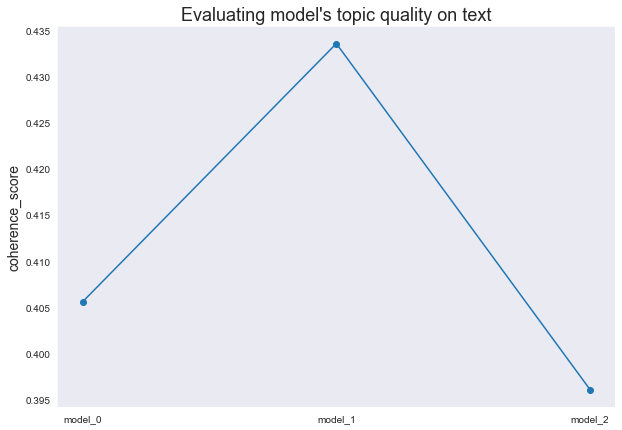

In [20]:
plt.figure(figsize=(10,7));
plt.plot(data['model'], data['coherence_score'], '-o');
plt.ylabel('coherence_score', size=14); 
plt.title("Evaluating model's topic quality on text", size=18);

# Best model

In [21]:
lda.create_topic_keywords_df()

topic_no,0,1,2,3,4,5,6
top_keywords,,,,,,,
0,patients,sequence,cells,epidemic,sequence,drug,estimate
1,test,sample,sequence,confirm,patients,structure,time
2,severe,test,protein,time,classification,protein,infect
3,clinical,result,structure,days,test,proteins,infection
4,report,detection,sarscov,report,mldspgui,sarscov,epidemic
5,cells,rna,bind,january,lombardy,analysis,population
6,include,genome,contain,measure,include,target,report
7,disease,two,two,outbreak,host,two,disease
8,show,one,domain,spread,confirm,infection,transmission


In [22]:
print('Best Coherence Score: ', lda.coherence_score)

Best Coherence Score:  0.4335546360844652


# Visualize Model

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda.lda_model, lda.corpus, lda.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.105368 -0.074722       1        1  26.926392
3      0.130134 -0.038635       2        1  25.376802
0      0.071222  0.145044       3        1  16.749729
1     -0.024463 -0.001814       4        1  14.786570
2     -0.166550 -0.005433       5        1   9.014836
5     -0.077614 -0.017472       6        1   6.153532
4     -0.038098 -0.006968       7        1   0.992136, topic_info=                            Term         Freq        Total Category  logprob  \
325                     patients  1172.000000  1172.000000  Default  30.0000   
432                     sequence   398.000000   398.000000  Default  29.0000   
72                         cells   262.000000   262.000000  Default  28.0000   
456                    structure   162.000000   162.000000  Default  27.0000   
417                       sample   303.000000   303.000000  Default  26.0000   
367                      protein   130.000000   130.000000  Default  25.0000   
583                     epidemic   533.000000   533.000000  Default  24.0000   
1072                        test   484.000000   484.000000  Default  23.0000   
586                     estimate   557.000000   557.000000  Default  22.0000   
420                      sarscov   140.000000   140.000000  Default  21.0000   
1385                        drug    87.000000    87.000000  Default  20.0000   
412                          rna   203.000000   203.000000  Default  19.0000   
436                       severe   259.000000   259.000000  Default  18.0000   
92                       confirm   442.000000   442.000000  Default  17.0000   
82                      clinical   268.000000   268.000000  Default  16.0000   
478                       target   130.000000   130.000000  Default  15.0000   
1990                        bind   101.000000   101.000000  Default  14.0000   
981                     proteins    82.000000    82.000000  Default  13.0000   
348                      predict   154.000000   154.000000  Default  12.0000   
851                       genome   136.000000   136.000000  Default  11.0000   
485                         time   646.000000   646.000000  Default  10.0000   
624                      january   265.000000   265.000000  Default   9.0000   
808                    detection   197.000000   197.000000  Default   8.0000   
1458                     persons   144.000000   144.000000  Default   7.0000   
215                        human   233.000000   233.000000  Default   6.0000   
222                      include   399.000000   399.000000  Default   5.0000   
1713                        host    79.000000    79.000000  Default   4.0000   
28                      analysis   304.000000   304.000000  Default   3.0000   
727                 transmission   339.000000   339.000000  Default   2.0000   
496                          two   366.000000   366.000000  Default   1.0000   
4257                    facility    23.354296    24.119799   Topic1  -7.2090   
9945         generation_interval    21.894535    22.659515   Topic1  -7.2736   
4450                    vehicles    18.847124    19.596643   Topic1  -7.4234   
3358                         cfr    72.820442    76.626167   Topic1  -6.0718   
9665                  households    20.083376    21.198833   Topic1  -7.3599   
9674          leisure_activities    13.177939    13.927607   Topic1  -7.7813   
9696            public_transport    39.272652    41.531403   Topic1  -6.6893   
10526           mortality_ratios    11.756694    12.471928   Topic1  -7.8954   
9634                  containers    11.727593    12.471726   Topic1  -7.8979   
11788                       init    10.272787    11.014890   Topic1  -8.0303   
9620                      berlin    11.625349    12.467965   Topic1  -7.9066   
8206                  extinction    11.221943    12.046480   Topic1  -7.9419   
12275                   wroc_la

# Top Topic Per Doc

In [24]:
df_top_topic_per_doc = lda.create_top_topic_per_doc_df(lda.corpus)

In [25]:
df_top_topic_per_doc.head(10)

,dominant_topic,topic_probability,topic_keywords
corpus_id,,,
0,0,0.7666,"patients, test, severe, clinical, report, cell..."
1,1,0.8299,"sequence, sample, test, result, detection, rna..."
2,6,0.5577,"estimate, time, infect, infection, epidemic, p..."
3,1,0.6744,"sequence, sample, test, result, detection, rna..."
4,3,0.729,"epidemic, confirm, time, days, report, january..."
5,0,0.6456,"patients, test, severe, clinical, report, cell..."
6,0,0.598,"patients, test, severe, clinical, report, cell..."
7,5,0.956,"drug, structure, protein, proteins, sarscov, a..."
8,0,0.9804,"patients, test, severe, clinical, report, cell..."


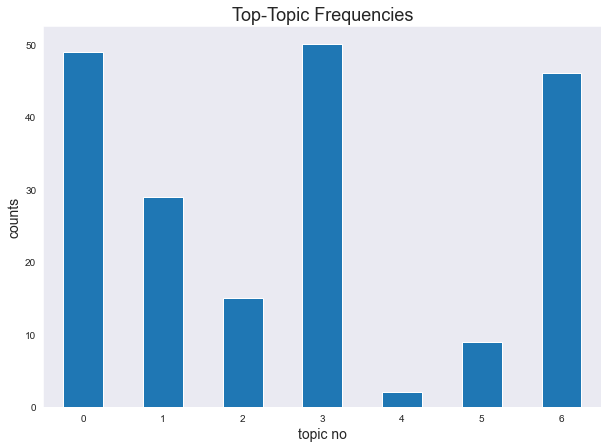

In [26]:
df_top_topic_per_doc.dominant_topic.value_counts().sort_index().plot(kind='bar', figsize=(10,7));
plt.xlabel('topic no', size=14); plt.ylabel('counts', size=14);
plt.title("Top-Topic Frequencies", size=18);
plt.xticks(rotation=0);

# Find the most representative document for each topic

In [27]:
topic_to_rep_id = lda.find_topic_to_rep_id()
for topic_no, corpus_id in topic_to_rep_id.items():
    kws = ", ".join(lda.get_topic_keywords(topic_no))
    rep = df.loc[corpus_id, 'meta']
    print(f"\nTopic {topic_no}\n" + 
          "-"*10 + "\n" +
          f"keywords: {kws}\n\n" + 
          f"meta:\n\n{rep}\n")


Topic 0
----------
keywords: patients, test, severe, clinical, report, cells, include, disease, show, result

meta:

Clinical characteristics of the recovered COVID-19 patients with re-detectable positive RNA test 

Background It has been reported that several cases recovered from COVID-19 tested positive for SARS-CoV-2 after discharge (re-detectable positive, RP), however the clinical characteristics, significance and potential cause of RP patients remained elusive.Methods A total of 262 COVID-19 patients were discharged from January 23 to February 25, 2020, and were enrolled for analysis of their clinical parameters. The RP and non-RP (NRP) patients were grouped according to the disease severity during their hospitalization period. The clinical characterization at re-admission to the hospital was analyzed. SARS-CoV-2 RNA and plasma antibody levels were detected using high-sensitive detection methods.Findings Up to March 10, 2020, all of patients were followed up for at least 14 days

# Evaluate model accuracy by comparing predictions on Text vs Meta

In [28]:
def predict_topic(lda, corpus):
    preds = []
    for doc in lda.lda_model[corpus]:
        dominant_topic,_ = max(doc[0], key=lambda x: x[1])
        preds.append(dominant_topic)

    return preds
            

In [31]:
# create test corpus for metadata
meta_data = df['clean_meta'].values.tolist()[:200]
meta_corpus = lda.create_corpus(meta_data)

# predict topics
meta_preds = predict_topic(lda, meta_corpus)
text_preds = predict_topic(lda, lda.corpus)

In [32]:
f1_score(text_preds, meta_preds, average='macro')

0.8169772299741663

In [33]:
cf_matrix = confusion_matrix(text_preds, meta_preds)

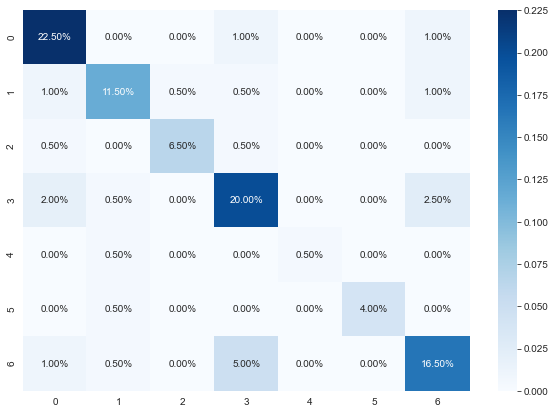

In [34]:
plt.figure(figsize=(10,7))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
             fmt='.2%', cmap='Blues');


In [35]:
gs_preds = {}
for model_no, d in gs_models.items():
    lda_model = d['lda_model']
    
    meta_preds = []
    for doc in lda_model[meta_corpus]:
        dominant_topic,_ = max(doc[0], key=lambda x: x[1])
        meta_preds.append(dominant_topic)
       
    text_preds = []
    for doc in lda_model[lda.corpus]:
        dominant_topic,_ = max(doc[0], key=lambda x: x[1])
        text_preds.append(dominant_topic)
        
    gs_preds[model_no] = f1_score(text_preds, meta_preds, average='macro')

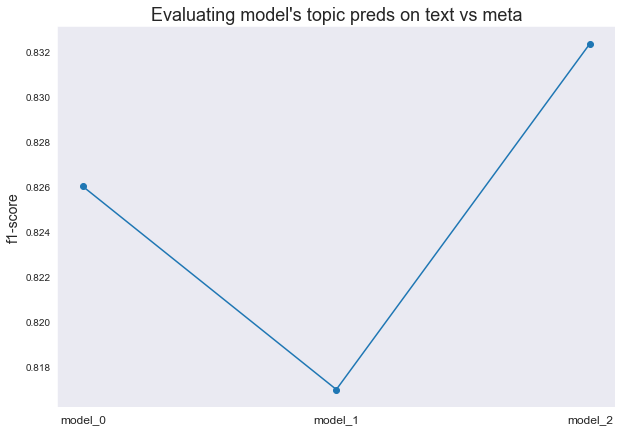

In [36]:
plt.figure(figsize=(10,7));
plt.plot(list(gs_preds.keys()), list(gs_preds.values()), '-o');
plt.xticks(size=12); plt.ylabel('f1-score', size=14); 
plt.title("Evaluating model's topic preds on text vs meta", size=18);

# Save Results

In [ ]:
# DATA_DIR = '../data/vasilis/lda/'
# lda.lda_model.save(DATA_DIR + 'lda_model')

In [ ]:
# import pickle

# with open(DATA_DIR + 'lda.pickle', 'wb') as handle:
#     pickle.dump(lda, handle, protocol=pickle.HIGHEST_PROTOCOL)

